This file is aimed towards beginners who are starting in the filed of deep learning and provides a step to step introduction to building a image classifier. This notebook uses the problem and dataset described in the [Deep Learning Beginner Challenge.](https://www.hackerearth.com/challenge/competitive/deep-learning-beginner-challenge/) at [HackerEarth](https://www.hackerearth.com/challenges/). 

### Importing libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from glob import glob
%matplotlib inline

### Data Exploration 

In [2]:
# Reading the train and test csv files 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [97]:
train.head()

Image_id           Animal
0  Img-1.jpg     hippopotamus
1  Img-2.jpg         squirrel
2  Img-3.jpg     grizzly+bear
3  Img-4.jpg               ox
4  Img-5.jpg  german+shepherd

In [4]:
# Number of images in the training and the test datasets. 
print('There are {} images in the train dataset.'.format(train.shape[0]))
print('There are {} images in the test datasets.'.format(test.shape[0]))

There are 13000 images in the train dataset.
There are 6000 images in the test datasets.


In [5]:
# Number of unique animals in the datasets
print('There are {} unique animals in the dataset.'.format(train.Animal.unique().shape[0]))

There are 30 unique animals in the dataset.


Lets see which Animals are there in the dataset.

In [6]:
print('The dataset contain images of the following animals:\n\n', train.Animal.unique())

The dataset contain images of the following animals:

 ['hippopotamus' 'squirrel' 'grizzly+bear' 'ox' 'german+shepherd' 'buffalo'
 'otter' 'bobcat' 'wolf' 'persian+cat' 'collie' 'antelope' 'seal'
 'dalmatian' 'siamese+cat' 'moose' 'horse' 'killer+whale' 'mouse' 'walrus'
 'beaver' 'rhinoceros' 'chimpanzee' 'weasel' 'spider+monkey' 'raccoon'
 'rat' 'chihuahua' 'mole' 'bat']


### Data Visualization

Now, that we have explored our dataset, let's implement some data visualization techniques to get a better understand of the data.

We will first start by analysing the frequency distribution of the animal images in the training data.

In [7]:
animal_count = pd.value_counts(train.Animal)

In [8]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=animal_count.index, y=animal_count.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation= 90)
ax.set_title('Frequency Distribution of the Animals in the Training Data')
ax.set(xlabel='Animals', ylabel='Count')
plt.show()

From the above distribution, we can infer that the animal 'horse' have the largest number of images in the dataset while 'mole' has the least number of images.

The distribution of the animals is skewed i.e. the classes to predict are unbalanced in the dataset. 

In [9]:
### Checking for any null values in the labels 
labels  =  train.Animal
labels.isnull().any()

False

Now, let's visulize the Images in the training data.

In [10]:
### Train adn Test image folder paths

TRAIN_PATH = '/Users/varishaganesh/Machine Learning/train/train/'
TEST_PATH = '/Users/varishaganesh/Machine Learning/test/test/'

Importing OpenCV and Python Image library for image manipulation.

In [11]:
### Importing Python Image Library and Opencv library
from PIL import Image
import cv2

Animal:  hippopotamus


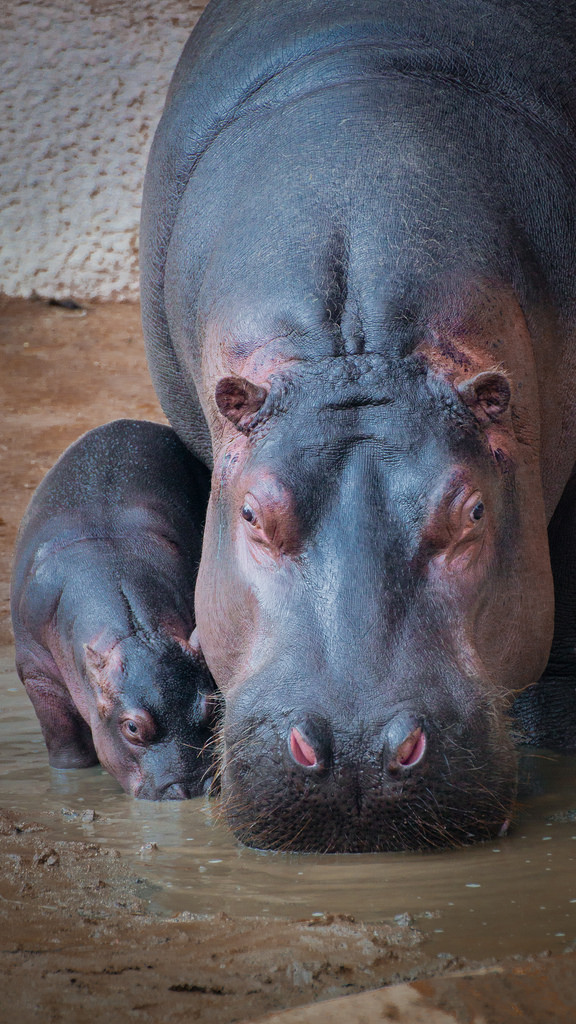

In [12]:
print('Animal: ',train.Animal[0])
Image.open(TRAIN_PATH + train.Image_id[0])

Using PIL(Python Image Library) Image function we can directly, view the Image stored in the given path. 

Now, let's use OpenCV to read the Image.

In [13]:
img = cv2.imread(TRAIN_PATH+train.Image_id[0])

We used the OpenCV 'imread' function and read the image stored at index zero of the train data.

Now, let's look how the computer interprets the image.

In [14]:
img

array([[[101, 103, 113],
        [ 96,  98, 108],
        [101, 103, 113],
        ...,
        [ 50,  45,  42],
        [ 48,  43,  40],
        [ 29,  24,  21]],

       [[105, 106, 116],
        [104, 106, 116],
        [110, 112, 122],
        ...,
        [ 48,  41,  38],
        [ 52,  45,  42],
        [ 49,  42,  39]],

       [[ 97,  98, 108],
        [ 98,  99, 109],
        [107, 108, 118],
        ...,
        [ 55,  48,  45],
        [ 48,  39,  36],
        [ 46,  37,  34]],

       ...,

       [[ 51,  64,  80],
        [ 49,  62,  78],
        [ 48,  61,  75],
        ...,
        [ 46,  60,  78],
        [ 46,  62,  79],
        [ 46,  62,  79]],

       [[ 50,  62,  74],
        [ 49,  60,  74],
        [ 49,  60,  74],
        ...,
        [ 44,  58,  76],
        [ 45,  59,  77],
        [ 45,  59,  77]],

       [[ 54,  63,  76],
        [ 52,  64,  76],
        [ 52,  64,  76],
        ...,
        [ 43,  57,  75],
        [ 44,  59,  75],
        [ 43,  58,  74]]

The computer cannot see shapes or colors. It reads an image as an array of numbers.

Next, we will check the dimensions of this array. 

In [15]:
### Shape of the image.
img.shape

(1024, 576, 3)

So, the computer inteprets the image as a three dimensional array of 1024 rows and 576 columns and with depth 3.  Each value in this array represents a pixel in the image, lying in the range (0 - 255). The depth 3 represents the RGB spectrum in the image. 

### Data Preprocessing 

Next, we will perform some preprocessing on the image data before supplying them to the training model.

In [16]:
### Displaying the image dimensions of the first five images in the training dataset. 
sample = train.head()
for idx in sample.Image_id:
    img = cv2.imread(TRAIN_PATH + idx)
    print('{} : {}'.format(idx, img.shape))

Img-1.jpg : (1024, 576, 3)
Img-2.jpg : (771, 1024, 3)
Img-3.jpg : (683, 1024, 3)
Img-4.jpg : (681, 1024, 3)
Img-5.jpg : (500, 332, 3)


We can see that all the images have different dimesions. But neural networks expect arrays of uniform dimensions as input. Therefore, we will resize the images in the dataset to the dimensions : (224 x 224 x 3)

In [17]:
### Creating a function to resize the images in the training data.
from tqdm import tqdm
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    return img

The above function reads an image and resizes it to 224 x 224 dimensions and returns it. 

In [18]:
#temp = train.sample(frac=0.3)
#train = temp.reset_index(drop=True)

In [19]:
train_img = []
for img_path in tqdm(train.Image_id.values):
    train_img.append(read_img(TRAIN_PATH + img_path))

100%|██████████| 13000/13000 [04:39<00:00, 46.44it/s]


In [20]:
import gc

Next, we will rescale the images in the training data. We will scale the width and height of each image so that each pixel value lies in the range of [0 - 1]. We will rescale each image by dividing it by 255. 

In [21]:
# Convert the image data into an array. 
# Since the range of color(RGB) is in the range of (0-255).
# Hence by dividing each image by 255, we convert the range to (0.0 - 1.0)

X_train = np.array(train_img, np.float32) / 255.

In [22]:
del train_img
gc.collect()

60

Next, we will calculate the mean and standard deviation of the images in the training dataset.

In [23]:
mean_img = X_train.mean(axis = 0)

In [24]:
std_dev = X_train.std(axis = 0)

Next, we will normalize the image data using the following formula: 

<center>** X = (x - mean of x)/(std. deviation of x)**<center/>

Normalization helps us to standardize the input values. Standardizing the inputs can make training faster and reduce the chances of getting stuck in local minima. Also, we like the features to haves similar ranges so that our gradients don't go out of control.

In [25]:
X_norm = (X_train - mean_img)/ std_dev

In [26]:
X_norm.shape

(13000, 224, 224, 3)

In [27]:
del X_train
gc.collect()

100

Next we label encode the lables in the train data. Label Encoding is used to transform non-numerical labels or categporical labels to numerical lables. 

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
lb = LabelEncoder()
lb.fit(train.Animal.values)
y = lb.transform(train.Animal.values)

In [30]:
from sklearn.model_selection import train_test_split

Finally, we create the training and validation sets. 

In [31]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X_norm, y, test_size=0.15, random_state=47)

In [32]:
del X_norm
gc.collect()

40

### Model Architecture


We will use the Keras framework to create our model. 

In [33]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


Next, we will one-hot encode the labels before supplying them to the model. Since label encoding (a.k.a integer encoding) will have a ordinal relationship between them. But for categorical variables where no such ordinall relationship exists, the integer encoding is not enough. In this case, one-hot encoding can be applied to the integer representation, where the integer enocoded variable is removed and a new binary variable is added for each unique integer value.  

In [34]:
#### One hot encoding labels.
ytrain = np_utils.to_categorical(ytrain)
yvalid = np_utils.to_categorical(yvalid)

We will build a model from scratch. We will use a Sequential model, which is a linear stack of layers, to build this model. 

In [35]:
model = Sequential()
model.add(BatchNormalization(input_shape = Xtrain.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, kernel_size=(3, 3), activation= 'relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation= 'relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(30, activation='softmax'))

In [36]:
### Generating a summary of the model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 218, 218, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 109, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 109, 109, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 107, 107, 128)    

There are approximately 11 million parameters to train. 

Next, we will define the loss function and the optimizer for the model.

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
early_stops = EarlyStopping(patience=5, monitor='val_acc')
checkpointer = ModelCheckpoint(filepath='weights.best.eda.hdf5', verbose=1, save_best_only=True)

In [39]:
model.fit(Xtrain, ytrain, validation_data=(Xvalid, yvalid), epochs=2, batch_size=16, verbose=1)

Train on 11050 samples, validate on 1950 samples
Epoch 1/2
11050/11050 [==============================] - 6012s 544ms/step - loss: 3.2423 - accuracy: 0.0948 - val_loss: 3.0590 - val_accuracy: 0.1544
Epoch 2/2
11050/11050 [==============================] - 5699s 516ms/step - loss: 2.9474 - accuracy: 0.1738 - val_loss: 2.8918 - val_accuracy: 0.1938


In [40]:
model.save_weights('weights.best.eda.hdf5')

### Prediction on Test Set

Now that we have built and trained our model, we will use it to predict the labels on the test images. 

In [41]:
test_img = []
for img_path in tqdm(test.Image_id.values):
    test_img.append(read_img(TEST_PATH + img_path))

100%|██████████| 6000/6000 [02:07<00:00, 47.14it/s]


In [42]:
X_test = np.array(test_img, np.float32)/255.

In [43]:
del test_img
gc.collect()

66

Performing normalization on the test images. 

In [44]:
X_norm_test = (X_test - mean_img) / std_dev

In [45]:
del X_test
gc.collect()

40

Predicting the labels on the test images.

In [46]:
y_test_pred = model.predict(X_norm_test)

In [47]:
### Creating the submission file
subm = pd.DataFrame()
subm['image_id'] = test.Image_id
label_df = pd.DataFrame(data=y_test_pred, columns=lb.classes_)

In [48]:
subm = pd.concat([subm, label_df], axis=1)

In [49]:
subm.to_csv('submission.csv', index=False)

In [50]:
subm

image_id  antelope       bat    beaver    bobcat   buffalo  \
0        Img-1.jpg  0.015297  0.095227  0.009599  0.001219  0.235911   
1        Img-2.jpg  0.153819  0.009673  0.020487  0.028051  0.013795   
2        Img-3.jpg  0.354804  0.003594  0.019202  0.020379  0.008081   
3        Img-4.jpg  0.015349  0.018175  0.003065  0.004789  0.034791   
4        Img-5.jpg  0.048254  0.048818  0.010063  0.004661  0.142615   
...            ...       ...       ...       ...       ...       ...   
5995  Img-5996.jpg  0.003868  0.013288  0.000163  0.000833  0.155964   
5996  Img-5997.jpg  0.263381  0.004401  0.028334  0.057672  0.005731   
5997  Img-5998.jpg  0.025799  0.007513  0.001235  0.045718  0.016027   
5998  Img-5999.jpg  0.040622  0.002586  0.004167  0.010922  0.008204   
5999  Img-6000.jpg  0.046428  0.009834  0.013465  0.018263  0.046454   

      chihuahua  chimpanzee    collie  dalmatian  ...   raccoon       rat  \
0      0.011419    0.035330  0.063788   0.050315  ...  0.003738  0.008394   
1      0.010935    0.005988  0.029296   0.005593  ...  0.008757  0.023869   
2      0.013354    0.002611  0.038910   0.001999  ...  0.004624  0.024816   
3      0.028897    0.054733  0.058205   0.071920  ...  0.014286  0.014380   
4      0.026096    0.046431  0.087625   0.042461  ...  0.034843  0.024659   
...         ...         ...       ...        ...  ...       ...       ...   
5995   0.001593    0.080152  0.145227   0.127929  ...  0.012532  0.000594   
5996   0.009487    0.005567  0.041807   0.004793  ...  0.014776  0.018956   
5997   0.022152    0.020190  0.151721   0.027106  ...  0.078963  0.006151   
5998   0.004960    0.054853  0.184628   0.071843  ...  0.023124  0.001861   
5999   0.005265    0.023659  0.024741   0.005960  ...  0.007885  0.007232   

      rhinoceros      seal  siamese+cat  spider+monkey  squirrel    walrus  \
0       0.019066  0.024073     0.010084       0.000912  0.007618  0.007993   
1       0.016796  0.167177     0.021086       0.003887  0.057827  0.023512   
2       0.010435  0.088324     0.021619       0.001943  0.056116  0.016899   
3       0.036077  0.045824     0.006297       0.014386  0.015497  0.005363   
4       0.025317  0.061824     0.041072       0.019417  0.007015  0.011232   
...          ...       ...          ...            ...       ...       ...   
5995    0.045899  0.001139     0.001951       0.008088  0.003177  0.000014   
5996    0.009006  0.085667     0.016860       0.004763  0.075498  0.014166   
5997    0.020290  0.003972     0.043070       0.013196  0.041686  0.000113   
5998    0.012041  0.026782     0.002386       0.013598  0.043299  0.001263   
5999    0.081069  0.303400     0.004726       0.006852  0.042968  0.010484   

        weasel      wolf  
0     0.005054  0.002299  
1     0.019380  0.030112  
2     0.014830  0.028673  
3     0.017435  0.011062  
4     0.005040  0.014878  
...        ...       ...  
5995  0.003498  0.004856  
5996  0.019719  0.037964  
5997  0.010454  0.070997  
5998  0.038061  0.008101  
5999  0.011526  0.014437  

[6000 rows x 31 columns]

In [87]:
table = subm.drop(columns=['image_id'])

In [88]:
table = table.drop(columns=['sub_category'])

In [101]:
final_output = table.idxmax(axis=1)
pd.set_option('display.max_rows', 6000)
final_output

0               buffalo
1                  seal
2              antelope
3                    ox
4               buffalo
5                  seal
6                 horse
7                 horse
8       german+shepherd
9                collie
10               collie
11               collie
12             antelope
13                 seal
14                 seal
15               collie
16      german+shepherd
17           chimpanzee
18             antelope
19                 seal
20                   ox
21                 seal
22               collie
23            dalmatian
24          persian+cat
25          persian+cat
26               collie
27          persian+cat
28          persian+cat
29               collie
30             antelope
31                horse
32             antelope
33                horse
34               collie
35          persian+cat
36             squirrel
37             antelope
38                horse
39            dalmatian
40               collie
41              

In [102]:
table.to_csv('predicted_animals.csv', index=False)

The submission produces a score of 3.140. Remember that this score is the log-loss error and therefore a perfect model will have a score close to 0 . Hence this model can be further improved in many ways. A better model will be posted in future.

END......